In [1]:
pip install pykonal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pykonal: filename=pykonal-0.4.1-cp310-cp310-linux_x86_64.whl size=13601537 sha256=7c03ae6b65b6df1952fe8fe53d12140e89555be66feb37edf9a5b64018cfc355
  Stored in directory: /root/.cache/pip/wheels/24/bd/f0/d68f7568556a6a7ed31ddee6ddc4b09cdf0a22724ffe9d3dcf
Successfully built pykonal


In [59]:
# Libraries for plotting and interfaces
import matplotlib
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import pkg_resources

# Libraries for computation
import numpy as np
from scipy.interpolate import CubicSpline
import os
import pykonal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
v = np.load("/content/drive/MyDrive/data_viking/semblance.npy")

In [6]:
v.shape

(100, 1500, 241)

In [7]:
v= v[:, :, :, np.newaxis]
v.shape

(100, 1500, 241, 1)

In [8]:
v.max(), v.min(), len(v)

(0.8382940308259785, 8.178498472459829e-05, 100)

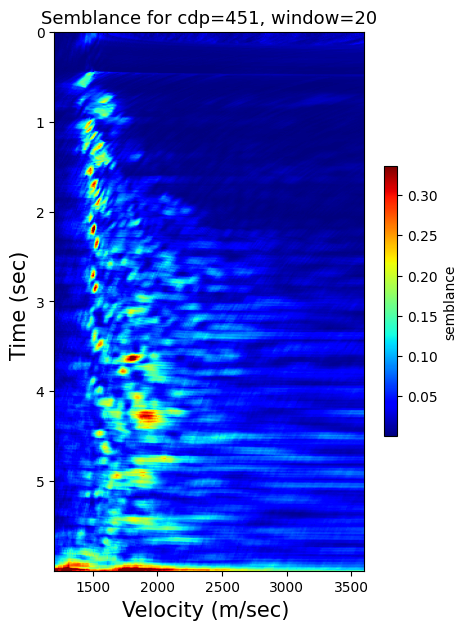

In [18]:
v1 = v[12]
cdp_no = 451
window = 20
plt.figure(figsize=(5,7))
plt.title(f'Semblance for cdp={cdp_no}, window={window}', fontsize=13)
plt.xlabel('Velocity (m/sec) ',fontsize=15)
plt.ylabel('Time (sec) ',fontsize=15)
aspect = 'auto'
vmin, vmax = np.percentile(v1, [0.1, 99.9])
img = plt.imshow(v1, extent=[1200, 3600, 5.996, 0],
  aspect=aspect, cmap='jet', vmin=vmin, vmax=vmax)  #clip*np.max(v1)
plt.colorbar(img, label="semblance",shrink=0.5, ax=plt.gca())
plt.show()

In [12]:
v1.max(), v1.max()

(0.49129436160599826, 0.49129436160599826)

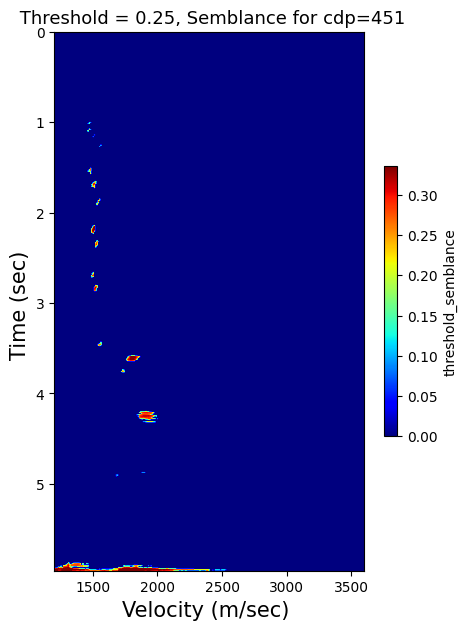

In [19]:
threshold = np.round(np.max(v1)*0.5, 2)
vth = np.where(v1>threshold, v1, 0)

plt.figure(figsize=(5,7))
plt.title(f' Threshold = {threshold}, Semblance for cdp={cdp_no}', fontsize=13)
plt.xlabel('Velocity (m/sec) ',fontsize=15)
plt.ylabel('Time (sec) ',fontsize=15)
aspect = 'auto'
vmin, vmax = np.percentile(vth, [0.1, 99.9])
img = plt.imshow(vth, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(img, label="threshold_semblance",shrink=0.5, ax=plt.gca())
plt.show()

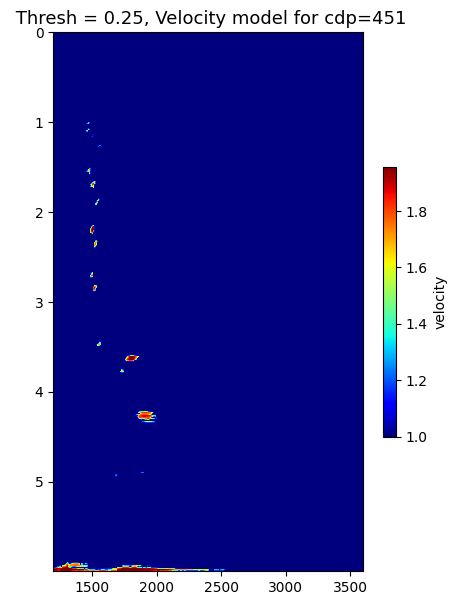

In [31]:
vv = np.exp(2*vth)
plt.figure(figsize=(5,7))
plt.title(f' Thresh = {threshold}, Velocity model for cdp={cdp_no}', fontsize=13)
#plt.xlabel('Velocity (m/sec) ',fontsize=15)
#plt.ylabel('Time (sec) ',fontsize=15)
aspect = 'auto'
vmin, vmax = np.percentile(vv, [0.1, 99.9])
img = plt.imshow(vv, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(img, label="velocity",shrink=0.5, ax=plt.gca())
plt.show()

In [21]:
velocity = pykonal.fields.ScalarField3D(coord_sys="cartesian")
velocity.min_coords = 0, 0, 0
velocity.node_intervals = 0.004, 0.01, 1
velocity.npts = vv.shape
velocity.values = vv

In [22]:
src_idx = (0, 20, 0)

In [23]:
solver_dg = pykonal.EikonalSolver(coord_sys="cartesian")
solver_dg.vv.min_coords = velocity.min_coords
solver_dg.vv.node_intervals = velocity.node_intervals
solver_dg.vv.npts = velocity.npts
solver_dg.vv.values = velocity.values

src_idx = src_idx
solver_dg.tt.values[src_idx] = 0
solver_dg.unknown[src_idx] = False
solver_dg.trial.push(*src_idx)
solver_dg.solve()

1

In [24]:
0.2/0.01

20.0

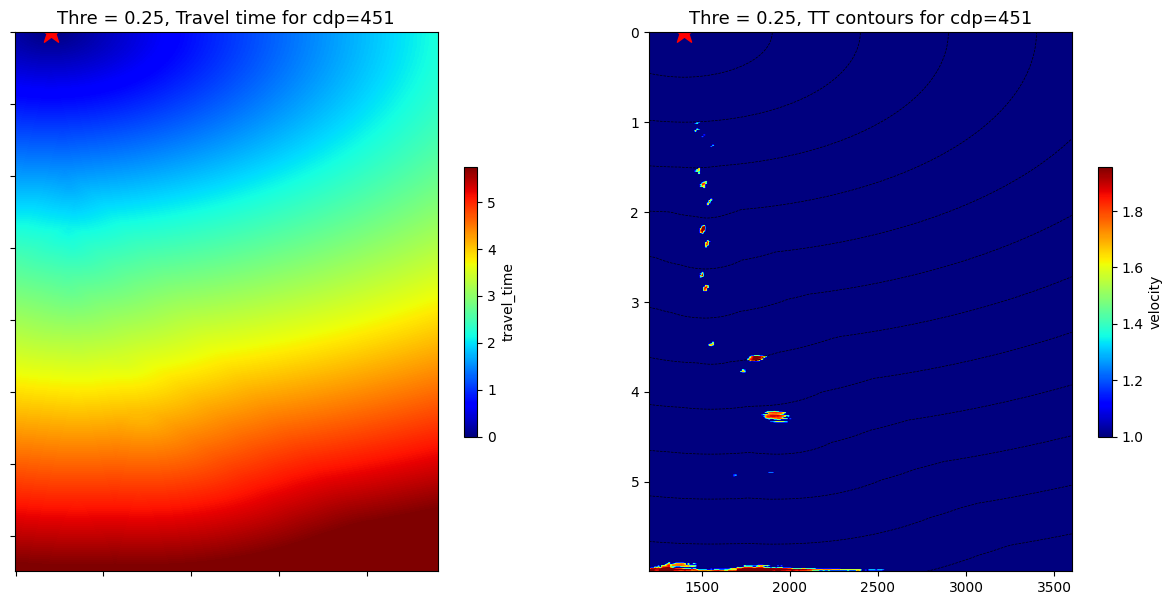

In [32]:
plt.figure(figsize=(15, 7))

ax1 = plt.subplot(121)
ax1.set_title(f'Thre = {threshold}, Travel time for cdp={cdp_no}', fontsize=13)

img = ax1.imshow(solver_dg.tt.values, cmap='jet', aspect='auto', vmin=0, vmax=0.9*solver_dg.tt.values.max())
ax1.scatter(src_idx[1], src_idx[0], marker='*', c='r', s=300, alpha=1)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.colorbar(img, label="travel_time",shrink=0.5, ax=ax1)

ax2 = plt.subplot(122)
ax2.set_title(f'Thre = {threshold}, TT contours for cdp={cdp_no}', fontsize=13)
vmin, vmax = np.percentile(solver_dg.vv.values, [0.1, 99.9])
img = ax2.imshow(solver_dg.vv.values, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
ax2.contour(np.arange(1200, 3610, 10), np.arange(0,6,0.004), solver_dg.tt.values[:, :, 0], colors="k",
            levels=np.arange(0, solver_dg.tt.values.max(), 0.50), linewidths=0.5, linestyles="--")
ax2.scatter(src_idx[1]*10 + 1200, src_idx[0], marker='*', c='r', s=300, alpha=1)
plt.colorbar(img, label="velocity",shrink=0.5, ax=ax2)
plt.show()

In [33]:
velocity.max_coords, velocity.npts

(array([5.996, 2.4  , 0.   ]), array([1500,  241,    1]))

In [34]:
(1.2/0.01)*10 + 1200

2400.0

In [35]:
ray = solver_dg.tt.trace_ray(np.array([5.996, 1.2, 0], dtype=float))
ray

array([[5.22266756e-04, 2.00030556e-01, 0.00000000e+00],
       [1.52226161e-03, 2.00033763e-01, 0.00000000e+00],
       [2.52225581e-03, 2.00037170e-01, 0.00000000e+00],
       ...,
       [5.99429444e+00, 1.19895547e+00, 0.00000000e+00],
       [5.99514571e+00, 1.19948020e+00, 0.00000000e+00],
       [5.99600000e+00, 1.20000000e+00, 0.00000000e+00]])

In [36]:
rcv_idx = np.array([5.996, 1.2, 0], dtype=float)
rcv_idx[0], (rcv_idx[1]/0.01)*10 + 1200

(5.996, 2400.0)

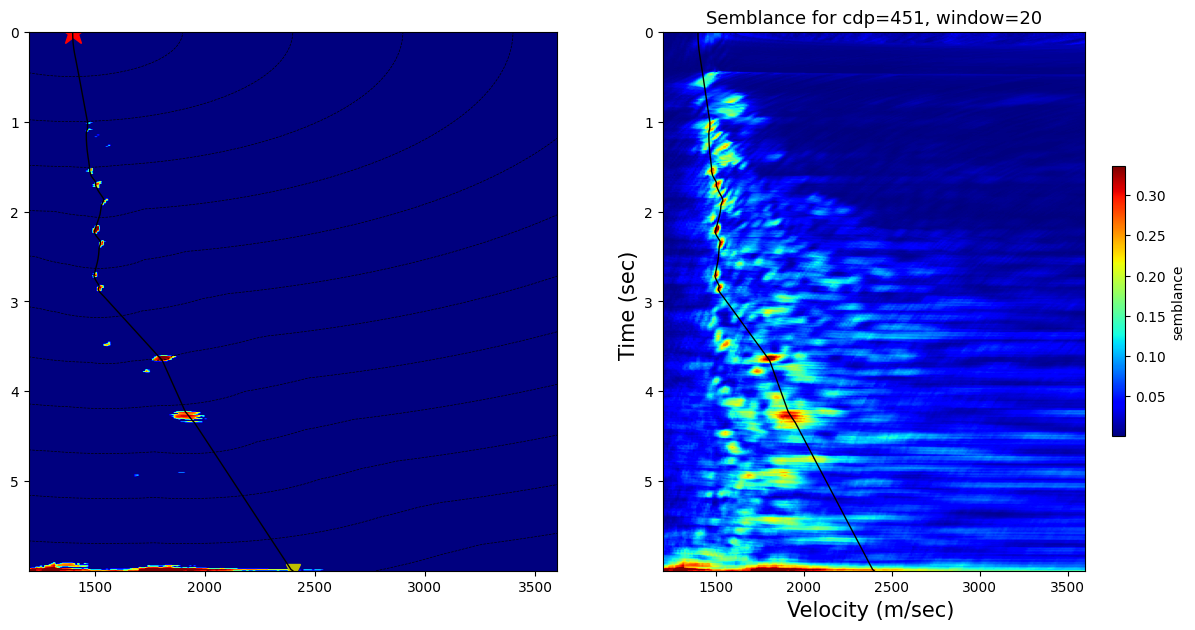

In [46]:
r1 = ray[:, 0]
r2 = (ray[:, 1]/0.01) *10 + 1200

plt.figure(figsize=(15,7))

ax1 = plt.subplot(121)
vmin, vmax = np.percentile(solver_dg.vv.values, [0.1, 99.9])
ax1.imshow(solver_dg.vv.values, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
ax1.contour(np.arange(1200, 3610, 10), np.arange(0,6,0.004), solver_dg.tt.values[:, :, 0], colors="k",
            levels=np.arange(0, solver_dg.tt.values.max(), 0.50), linewidths=0.5, linestyles="--")
ax1.plot(src_idx[1]*10 + 1200, src_idx[0], marker='*', linestyle='None', color='r', markersize=20)
ax1.plot((rcv_idx[1]/0.01)*10 + 1200, rcv_idx[0], marker='v', linestyle='None', color='y', markersize=10)
ax1.plot(r2, r1, color="k", linewidth=1)


ax2 = plt.subplot(122)
ax2.set_title(f'Semblance for cdp={cdp_no}, window={window}', fontsize=13)
ax2.set_xlabel('Velocity (m/sec) ',fontsize=15)
ax2.set_ylabel('Time (sec) ',fontsize=15)
aspect = 'auto'
vmin, vmax = np.percentile(v1, [0.1, 99.9])
img = ax2.imshow(v1, extent=[1200, 3600, 5.996, 0], aspect=aspect, cmap='jet', vmin=vmin, vmax=vmax)
ax2.plot(r2, r1, color="k", linewidth=1)
plt.colorbar(img, label="semblance",shrink=0.5, ax=ax2)

plt.show()


In [47]:
times = np.arange(0, 6, 0.004)
velocity = np.interp(times, r1, r2)
velocity.shape

(1500,)

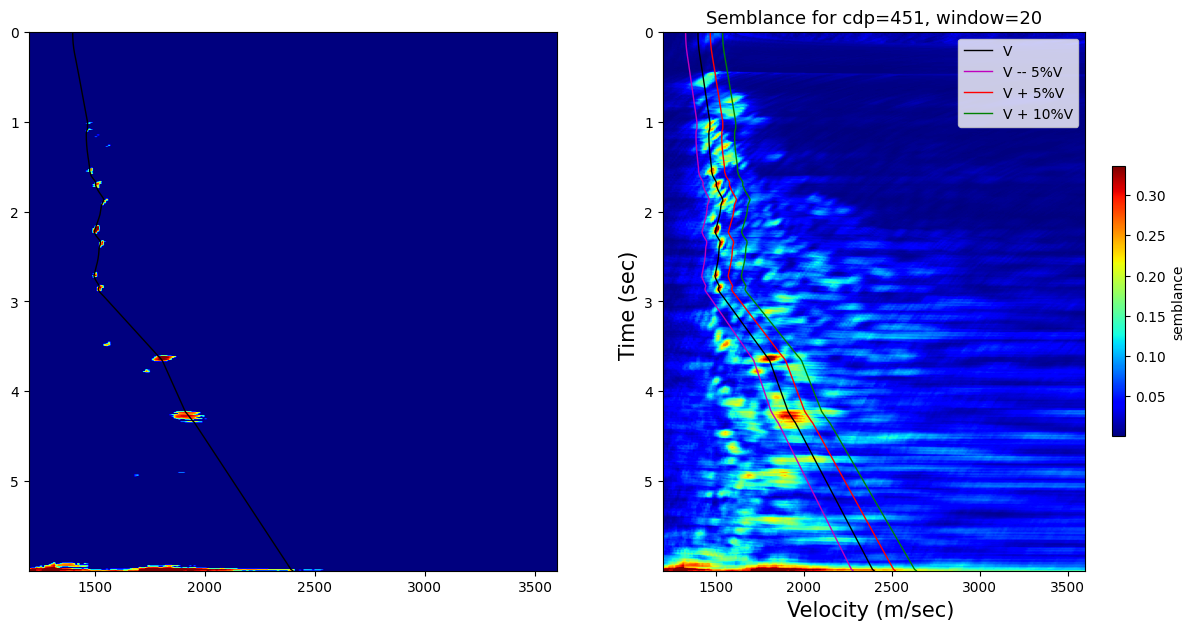

In [53]:
plt.figure(figsize=(15,7))

ax1 = plt.subplot(121)
vmin, vmax = np.percentile(solver_dg.vv.values, [0.1, 99.9])
ax1.imshow(solver_dg.vv.values, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
ax1.plot(r2, r1, color="k", linewidth=1)

ax2 = plt.subplot(122)
ax2.set_title(f'Semblance for cdp={cdp_no}, window={window}', fontsize=13)
ax2.set_xlabel('Velocity (m/sec) ',fontsize=15)
ax2.set_ylabel('Time (sec) ',fontsize=15)
vmin, vmax = np.percentile(v1, [0.1, 99.9])
img = ax2.imshow(v1, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
ax2.plot(velocity, times, color="k", linewidth=1, label="V")
ax2.plot(velocity - velocity*0.05, times, color="m", linewidth=1, label="V -- 5%V")
ax2.plot(velocity +  velocity*0.05, times, color="r", linewidth=1, label="V + 5%V")
ax2.plot(velocity + velocity*0.10, times, color="g", linewidth=1, label="V + 10%V")
plt.colorbar(img, label="semblance",shrink=0.5, ax=ax2)
ax2.legend()

plt.show()

In [54]:
cdp = np.load("/content/drive/MyDrive/data_viking/cdp.npy")
offset = np.load("/content/drive/MyDrive/data_viking/offset.npy")

In [55]:
cdp.shape, offset.shape

((100, 1500, 60), (100, 60))

In [56]:
offset[12].shape

(60,)

In [57]:
offset1 = offset[12]
cdp1 = cdp[12]

In [71]:
def reflection_time(time : float, offset : np.ndarray, velocity : float) -> np.ndarray :
    """
    Input :
        time : float
                zeor-offset time

        offset : np.ndarray
                  array of offset's

        velocity : float
                    a value of velocity

    Returns:
        reflection_time : np.ndarray
                          array containg the reflection time corresponding to a time, velocity and array of offset's
    """
    t = np.sqrt(time**2 + offset**2/velocity**2)
    return t

In [72]:
def nmo_correction(cmp : np.ndarray, times : np.ndarray, cmp_offsets : np.ndarray, velocities : np.ndarray, stretch_mute=None) -> np.ndarray :
    """
    Input :
        cmp : np.ndarray
              Contain cdp gather for a unique cdp.

        times : np.ndarray
                array containing the time values for the ray trace from source to receiver

        cmp_offsets : np.ndarray
                  Contain cdp_offset's corresponding to the unique cdp no.

        velocities : np.ndarray
                    array containing the velocity values for the ray trace from source to receiver

        stretch_mute : default None, float
                        value above which you want to apply the mute

    Returns:
        nmo_correct : np.ndarray
                      Contain nmo corrected gather corresponding to the cdp gather.
    """
    nmo = np.zeros_like(cmp)
    for j, x in enumerate(cmp_offsets):
        t = [reflection_time(t0, x, velocities[i]) for i, t0 in enumerate(times)]
        interpolator = CubicSpline(times, cmp[:, j], extrapolate=False)
        amps = np.nan_to_num(interpolator(t), copy=False)
        nmo[:, j] = amps
        if stretch_mute is not None:
            nmo[np.abs((times-t)/(times+1e-10)) > stretch_mute, j] = 0
    return nmo

In [73]:
nmo_0 = nmo_correction(cdp1, times, offset1, velocity, stretch_mute=None)

In [74]:
nmo_m0 = nmo_correction(cdp1, times, offset1, velocity, stretch_mute=0.3)

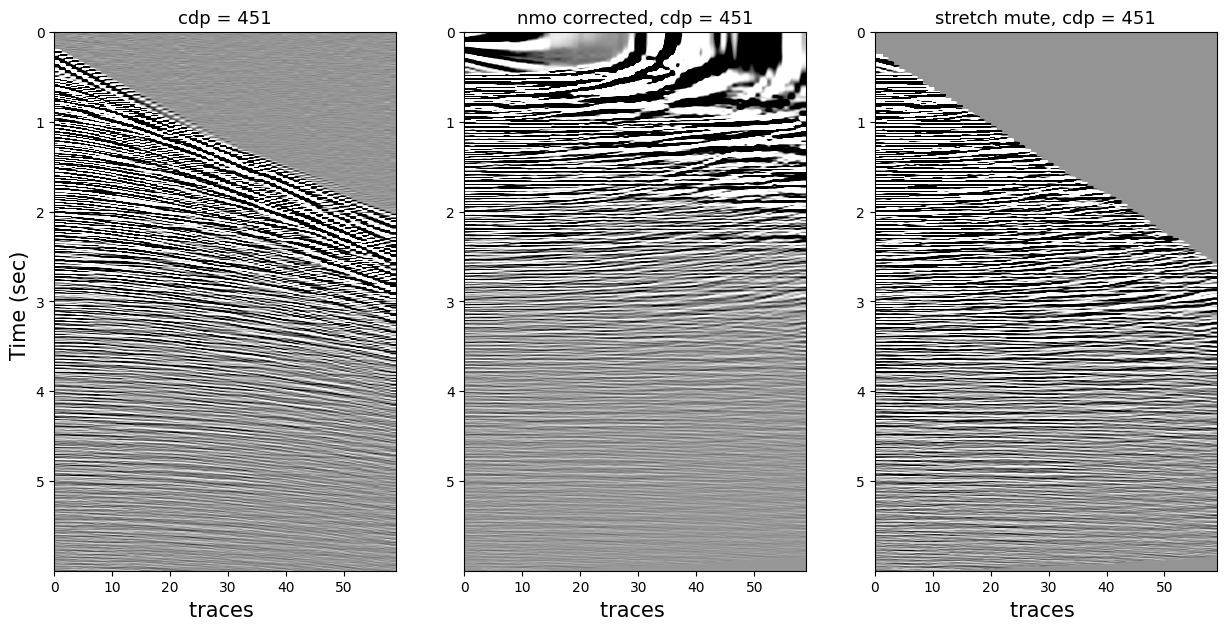

In [77]:
plt.figure(figsize=(15,7))

ax0 = plt.subplot(131)
ax0.set_title(f'cdp = {cdp_no}', fontsize=13)
ax0.set_xlabel('traces ',fontsize=15)
ax0.set_ylabel('Time (sec) ',fontsize=15)
vmin, vmax = np.percentile(cdp1, [15, 85])
ax0.imshow(cdp1, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

ax1 = plt.subplot(132)
ax1.set_title(f'nmo corrected, cdp = {cdp_no}', fontsize=13)
ax1.set_xlabel('traces ',fontsize=15)
vmin, vmax = np.percentile(nmo_0, [15, 85])
ax1.imshow(nmo_0, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

ax2 = plt.subplot(133)
ax2.set_title(f'stretch mute, cdp = {cdp_no}', fontsize=13)
ax2.set_xlabel('traces ',fontsize=15)
vmin, vmax = np.percentile(nmo_m0, [15, 85])
ax2.imshow(nmo_m0, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)
plt.show()

In [78]:
nmo_m1 = nmo_correction(cdp1, times, offset1, velocity - 0.05*velocity, stretch_mute=0.3)
nmo_m2 = nmo_correction(cdp1, times, offset1, velocity + 0.05*velocity, stretch_mute=0.3)
nmo_m3 = nmo_correction(cdp1, times, offset1, velocity + 0.10*velocity, stretch_mute=0.3)

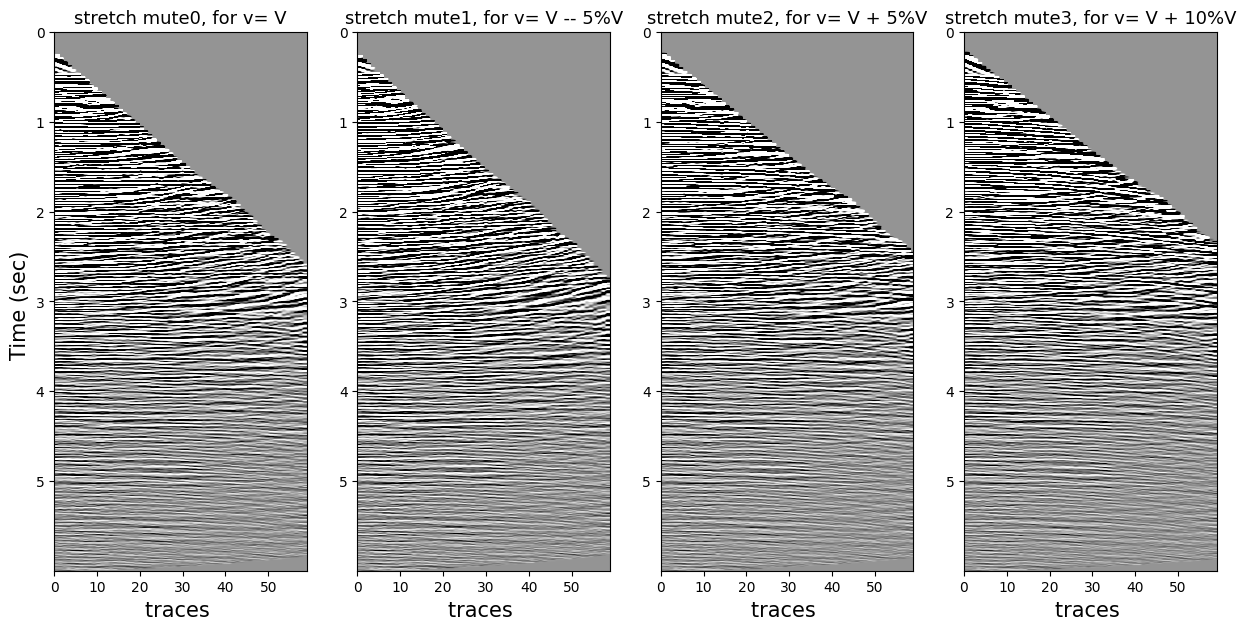

In [80]:
plt.figure(figsize=(15,7))

ax0 = plt.subplot(141)
ax0.set_title(f'stretch mute0, for v= V', fontsize=13)
ax0.set_ylabel('Time (sec) ',fontsize=15)
ax0.set_xlabel('traces ',fontsize=15)
vmin, vmax = np.percentile(nmo_m0, [15, 85])
ax0.imshow(nmo_m0, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

ax1 = plt.subplot(142)
ax1.set_title('stretch mute1, for v= V -- 5%V', fontsize=13)
ax1.set_xlabel('traces ',fontsize=15)
vmin, vmax = np.percentile(nmo_m1, [15, 85])
ax1.imshow(nmo_m1, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

ax2 = plt.subplot(143)
ax2.set_title('stretch mute2, for v= V + 5%V', fontsize=13)
ax2.set_xlabel('traces ',fontsize=15)
vmin, vmax = np.percentile(nmo_m2, [15, 85])
ax2.imshow(nmo_m2, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

ax3 = plt.subplot(144)
ax3.set_title('stretch mute3, for v= V + 10%V', fontsize=13)
ax3.set_xlabel('traces ',fontsize=15)
vmin, vmax = np.percentile(nmo_m3, [15, 85])
ax3.imshow(nmo_m3, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
# Computing for all the cdps from cdp no 438 to 538 having fold 60

In [91]:
paths = ['/content/semb_img', '/content/thre_semb_img', '/content/vel_model_img', '/content/travel_time_img',
         '/content/tt_velocity_pick_img', '/content/cdp_img', '/content/velocity_diff_img', '/content/nmo_cor_img', "/content/combined_img"]
for path in paths:
  os.mkdir(path)

In [90]:
import shutil

# Specify the directory path
for path in paths:
  shutil.rmtree(path)

In [93]:
from PIL import Image
v = np.load("/content/drive/MyDrive/data_viking/semblance.npy")

v = v[:, :, :, np.newaxis]

cdp = np.load("/content/drive/MyDrive/data_viking/cdp.npy")
offset = np.load("/content/drive/MyDrive/data_viking/offset.npy")

window = 20
cdp_no = 438
for (vel, cmp, off) in zip(v, cdp, offset):
  fig = plt.figure(figsize=(5,8))
  plt.title(f'Semb for cdp={cdp_no}, w={window}', fontsize=13)
  plt.xlabel('Velocity (m/sec) ',fontsize=15)
  plt.ylabel('Time (sec) ',fontsize=15)
  aspect = 'auto'
  clip=0.9
  img = plt.imshow(vel, extent=[1200, 3600, 5.996, 0], aspect=aspect, cmap='jet', vmin=0, vmax=clip*np.max(vel))
  plt.colorbar(img, label="semblance",shrink=0.5, ax=plt.gca())
  fig.savefig(f'/content/semb_img/semblance_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  threshold = np.round(np.max(vel)*0.5, 2)
  vth = np.where(vel>threshold, vel, 0)
  fig = plt.figure(figsize=(5,8))
  plt.title(f'Threh = {threshold}, Semb for cdp={cdp_no}, w={window}', fontsize=13)
  plt.xlabel('Velocity (m/sec) ',fontsize=15)
  plt.ylabel('Time (sec) ',fontsize=15)
  img = plt.imshow(vth, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect=aspect, vmin=0, vmax=clip*vth.max())
  plt.colorbar(img, label="threshold_semblance",shrink=0.5, ax=plt.gca())
  fig.savefig(f'/content/thre_semb_img/thre_{threshold}_semblance_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  vv = np.exp(2*vth)
  fig = plt.figure(figsize=(5,8))
  plt.title(f'Thre = {threshold}, Velovity model for cdp={cdp_no}', fontsize=13)
  plt.xlabel('Velocity (m/sec) ',fontsize=15)
  plt.ylabel('Time (sec) ',fontsize=15)
  img = plt.imshow(vv, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=0, vmax=0.9*vv.max())
  plt.colorbar(img, label="velocity",shrink=0.5, ax=plt.gca())
  fig.savefig(f'/content/vel_model_img/thre_{threshold}_velocity_model_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  velocity = pykonal.fields.ScalarField3D(coord_sys="cartesian")
  velocity.min_coords = 0, 0, 0
  velocity.node_intervals = 0.004, 0.01, 1
  velocity.npts = vv.shape
  velocity.values = vv

  solver_ek = pykonal.EikonalSolver(coord_sys="cartesian")
  solver_ek.vv.min_coords = velocity.min_coords
  solver_ek.vv.node_intervals = velocity.node_intervals
  solver_ek.vv.npts = velocity.npts
  solver_ek.vv.values = velocity.values

  src_idx = 0, 20, 0
  solver_ek.tt.values[src_idx] = 0
  solver_ek.unknown[src_idx] = False
  solver_ek.trial.push(*src_idx)
  solver_ek.solve()


  fig = plt.figure(figsize=(15,8))

  ax1 = plt.subplot(121)
  ax1.set_title(f'Thre = {threshold}, Travel time for cdp={cdp_no}', fontsize=13)
  img = ax1.imshow(solver_ek.tt.values, cmap='jet', aspect='auto', vmin=0, vmax=0.9*solver_ek.tt.values.max())
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  plt.colorbar(img, label="travel time",shrink=0.5, ax=ax1)

  ax2 = plt.subplot(122)
  ax2.set_title(f'Thre = {threshold}, TT contours for cdp={cdp_no}', fontsize=13)
  img = ax2.imshow(solver_ek.vv.values, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=0, vmax=0.9*vv.max())
  ax2.contour(np.arange(1200, 3610, 10), np.arange(0,6,0.004), solver_ek.tt.values[:, :, 0], colors="k",
              levels=np.arange(0, solver_ek.tt.values.max(), 0.50), linewidths=0.5, linestyles="--")
  plt.colorbar(img, label="velocity",shrink=0.5, ax=ax2)

  fig.savefig(f'/content/travel_time_img/thre_{threshold}_tt_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  ray = solver_ek.tt.trace_ray(np.array([5.996, 1.0, 0], dtype=float))

  r1 = ray[:, 0]
  r2 = (ray[:, 1]/0.01) *10 + 1200

  times = np.arange(0, 6, 0.004)
  velocity = np.interp(times, r1, r2)

  fig = plt.figure(figsize=(15,8))

  ax1 = plt.subplot(121)
  ax1.set_title(f'Thre = {threshold}, TT contours for cdp={cdp_no}', fontsize=13)
  ax1.imshow(solver_ek.vv.values, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=0, vmax=0.9*solver_ek.vv.values.max())
  ax1.contour(np.arange(1200, 3610, 10), np.arange(0,6,0.004), solver_ek.tt.values[:, :, 0], colors="k",
              levels=np.arange(0, solver_ek.tt.values.max(), 0.50), linewidths=0.5, linestyles="--")
  ax1.plot(r2, r1, color="k", linewidth=1)

  ax2 = plt.subplot(122)
  ax2.set_title(f'Thre = {threshold}, Semb for cdp={cdp_no}, window={window}', fontsize=13)
  ax2.set_xlabel('Velocity (m/sec) ',fontsize=15)
  ax2.set_ylabel('Time (sec) ',fontsize=15)
  img = ax2.imshow(vel, extent=[1200, 3600, 5.996, 0], cmap='jet', aspect='auto', vmin=0, vmax=clip*vel.max())
  ax2.plot(velocity, times, color="k", linewidth=1)
  plt.colorbar(img, label="semblance",shrink=0.5, ax=ax2)
  fig.savefig(f'/content/tt_velocity_pick_img/velocity_pick_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)


  fig = plt.figure(figsize=(6,8))
  plt.title(f'Semb for cdp={cdp_no}, w={window}', fontsize=13)
  plt.xlabel('Velocity (m/sec) ',fontsize=15)
  plt.ylabel('Time (sec) ',fontsize=15)
  aspect = 'auto'
  clip=0.9
  img = plt.imshow(vel, extent=[1200, 3600, 5.996, 0], aspect=aspect, cmap='jet', vmin=0, vmax=clip*np.max(vel))
  plt.colorbar(img, label="semblance",shrink=0.5, ax=plt.gca())
  plt.plot(velocity, times, color="k", linewidth=1, label="V ")
  plt.plot(velocity - velocity*0.05, times, color="m", linewidth=1, label="V -- 5%V")
  plt.plot(velocity +  velocity*0.05, times, color="r", linewidth=1, label="V + 5%V")
  plt.plot(velocity + velocity*0.10, times, color="g", linewidth=1, label="V + 10%V")
  plt.legend()
  fig.savefig(f'/content/velocity_diff_img/velocity1_pick_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  nmo_0 = nmo_correction(cmp, times, off, velocity, stretch_mute=None)

  nmo_m0 = nmo_correction(cmp, times, off, velocity, stretch_mute=0.3)

  fig = plt.figure(figsize=(15,8))

  ax0 = plt.subplot(131)
  ax0.set_title(f'cdp = {cdp_no}', fontsize=13)
  ax0.set_xlabel('traces ',fontsize=15)
  ax0.set_ylabel('Time (sec) ',fontsize=15)
  vmin, vmax = np.percentile(cmp, [15, 85])
  ax0.imshow(cmp, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

  ax1 = plt.subplot(132)
  ax1.set_title(f'nmo corrected, cdp = {cdp_no}', fontsize=13)
  vmin, vmax = np.percentile(nmo_0, [15, 85])
  ax1.imshow(nmo_0, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

  ax2 = plt.subplot(133)
  ax2.set_title(f'stretch mute0, for v= V', fontsize=13)
  vmin, vmax = np.percentile(nmo_m0, [15, 85])
  ax2.imshow(nmo_m0, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

  fig.savefig(f'/content/cdp_img/nmo_corr_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  v1 = velocity - 0.05*velocity

  nmo_m1 = nmo_correction(cmp, times, off, v1, stretch_mute=0.3)

  v2 = velocity + 0.05*velocity

  nmo_m2 = nmo_correction(cmp, times, off, v2, stretch_mute=0.3)

  v3 = velocity + 0.10*velocity

  nmo_m3 = nmo_correction(cmp, times, off, v3, stretch_mute=0.3)

  fig = plt.figure(figsize=(15,8))

  ax0 = plt.subplot(131)
  ax0.set_title('stretch mute1, for v= V -- 5%V', fontsize=13)
  ax0.set_xlabel('traces ',fontsize=15)
  ax0.set_ylabel('Time (sec) ',fontsize=15)
  vmin, vmax = np.percentile(nmo_m1, [15, 85])
  ax0.imshow(nmo_m1, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

  ax1 = plt.subplot(132)
  ax1.set_title('stretch mute2, for v= V + 5%V', fontsize=13)
  vmin, vmax = np.percentile(nmo_m2, [15, 85])
  ax1.imshow(nmo_m2, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

  ax2 = plt.subplot(133)
  ax2.set_title('stretch mute3, for v= V + 10%V', fontsize=13)
  vmin, vmax = np.percentile(nmo_m3, [15, 85])
  ax2.imshow(nmo_m3, cmap='Greys', extent=[0, 59, 5.996, 0], aspect='auto', vmin=vmin, vmax=vmax)

  fig.savefig(f'/content/nmo_cor_img/nmute_cor_cdp_{cdp_no}.png', dpi=100)
  plt.close(fig)

  image_files = [f"/content/semb_img/semblance_cdp_{cdp_no}.png", f'/content/thre_semb_img/thre_{threshold}_semblance_cdp_{cdp_no}.png',

                f'/content/vel_model_img/thre_{threshold}_velocity_model_cdp_{cdp_no}.png',

                f'/content/travel_time_img/thre_{threshold}_tt_cdp_{cdp_no}.png',f'/content/tt_velocity_pick_img/velocity_pick_cdp_{cdp_no}.png',

                f'/content/velocity_diff_img/velocity1_pick_cdp_{cdp_no}.png',

                f'/content/cdp_img/nmo_corr_cdp_{cdp_no}.png', f'/content/nmo_cor_img/nmute_cor_cdp_{cdp_no}.png']

  images = [Image.open(filename) for filename in image_files]
  widths, heights = zip(*(i.size for i in images))
  total_width = sum(widths)
  max_height = max(heights)
  combined_image = Image.new("RGB", (total_width, max_height))

  # Paste each image into the combined image
  x_offset = 0
  for img in images:
      combined_image.paste(img, (x_offset, 0))
      x_offset += img.width

  # Save the combined image
  combined_image.save(f"/content/combined_img/cdp_{cdp_no}_combined_img.png")


  cdp_no += 1

plt.show()